# Modelado baseline - Machine Learning Clásico

Este notebook implementa modelos baseline de Machine Learning para clasificar cuatro estados fisiológicos:
- rest: Estado de reposo
- stress: Estrés agudo inducido
- aerobic: Ejercicio aeróbico
- anaerobic: Ejercicio anaeróbico

**Objetivo**: Establecer un baseline de rendimiento con modelos clásicos de ML que servirá como punto de referencia para los modelos de Deep Learning que implementaremos posteriormente.

## Estrategia de Evaluación

1. Baseline con Random Split (70/30): Rendimiento optimista con datos del mismo pool de sujetos
2. Leave-One-Subject-Out (LOSO): Evaluación realista de generalización inter-sujeto

## Modelos Baseline Evaluados

- Random Forest: Ensamble de árboles de decisión
- XGBoost: Gradient boosting optimizado
- SVM: Support Vector Machine con kernel RBF
- Gradient Boosting: Boosting secuencial de árboles

## 1. Importación de Librerías

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    confusion_matrix, 
    classification_report,
    balanced_accuracy_score
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

## 2. Carga de Datos y Verificaciones Básicas

In [29]:
df = pd.read_csv('../data/dataset_features_advanced.csv')

print(f"Shape del dataset: {df.shape}")
print(f"\nDistribución de clases:")
print(df['label'].value_counts())
print(f"\nNúmero de sujetos: {df['subject_id'].nunique()}")

Shape del dataset: (1976, 43)

Distribución de clases:
label
rest         634
aerobic      611
stress       267
anaerobic    236
unknown      228
Name: count, dtype: int64

Número de sujetos: 39


Chequeo de calidad del dataset (solo como verificación):

In [30]:
missing = df.isnull().sum().sum()
inf_count = np.isinf(df.select_dtypes(include=[np.number])).sum().sum()

print(f"Valores faltantes: {missing}")
print(f"Valores infinitos: {inf_count}")

if missing > 0 or inf_count > 0:
    print("\nSe detectaron problemas de calidad en los datos!!")
else:
    print("\nDatos listos para modelado")

Valores faltantes: 0
Valores infinitos: 0

Datos listos para modelado


## 3. Preparación de Datos

In [31]:
feature_cols = [c for c in df.columns if c not in ['subject_id', 'condition', 'label']]
X = df[feature_cols].values
y = df['label'].values
subjects = df['subject_id'].values

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Features: {len(feature_cols)}")
print(f"\nMAPEO DE ETIQUETAS:")
for i, label in enumerate(le.classes_):
    print(f"  {label} -> {i}")

Features: 40

MAPEO DE ETIQUETAS:
  aerobic -> 0
  anaerobic -> 1
  rest -> 2
  stress -> 3
  unknown -> 4


## 4. Evaluación Baseline: División Aleatoria 70/30

Primera evaluación con división estratificada. Esto proporciona una **cota superior optimista** del rendimiento, ya que train y test comparten sujetos.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.30, 
    stratify=y, 
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train.shape[0]} muestras")
print(f"Test set: {X_test.shape[0]} muestras")

Train set: 1383 muestras
Test set: 593 muestras


### 4.1 Random Forest

In [33]:
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf_clf.fit(X_train_scaled, y_train)
pred_rf = rf_clf.predict(X_test_scaled)

acc_rf = accuracy_score(y_test, pred_rf)
f1_rf = f1_score(y_test, pred_rf, average='macro')
balanced_acc_rf = balanced_accuracy_score(y_test, pred_rf)

print("RANDOM FOREST")
print(f"Accuracy: {acc_rf:.4f}")
print(f"Balanced Accuracy: {balanced_acc_rf:.4f}")
print(f"Macro F1-Score: {f1_rf:.4f}")
print(f"\n{classification_report(y_test, pred_rf)}")

RANDOM FOREST
Accuracy: 0.6796
Balanced Accuracy: 0.6446
Macro F1-Score: 0.6596

              precision    recall  f1-score   support

     aerobic       0.72      0.90      0.80       183
   anaerobic       0.78      0.65      0.71        71
        rest       0.61      0.58      0.60       190
      stress       0.64      0.59      0.61        80
     unknown       0.69      0.51      0.58        69

    accuracy                           0.68       593
   macro avg       0.69      0.64      0.66       593
weighted avg       0.68      0.68      0.67       593


              precision    recall  f1-score   support

     aerobic       0.72      0.90      0.80       183
   anaerobic       0.78      0.65      0.71        71
        rest       0.61      0.58      0.60       190
      stress       0.64      0.59      0.61        80
     unknown       0.69      0.51      0.58        69

    accuracy                           0.68       593
   macro avg       0.69      0.64      0.66      

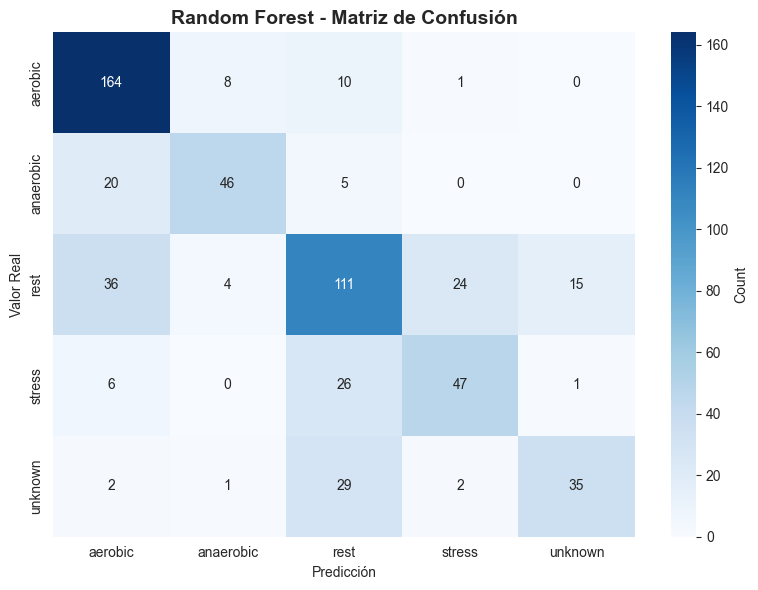

In [34]:
cm_rf = confusion_matrix(y_test, pred_rf, labels=le.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Random Forest - Matriz de Confusión', fontsize=14, fontweight='bold')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

### 4.2 Support Vector Machine

Support Vector Machine (SVM) es un clasificador supervisado que busca la frontera que mejor separa las clases maximizando el margen entre los datos más cercanos (los llamados “vectores de soporte”) y el hiperplano de decisión. Aporta una alternativa no lineal (gracias al kernel RBF) capaz de captar límites complejos entre estados fisiológicos. Esto te permite contrastar su rendimiento frente a Random Forest, Gradient Boosting y XGBoost antes de pasar a modelos de Deep Learning.

In [35]:
svm_clf = SVC(
    kernel='rbf', 
    C=10, 
    gamma='scale', 
    probability=True, 
    random_state=42,
    class_weight='balanced'
)

svm_clf.fit(X_train_scaled, y_train)
pred_svm = svm_clf.predict(X_test_scaled)

acc_svm = accuracy_score(y_test, pred_svm)
f1_svm = f1_score(y_test, pred_svm, average='macro')
balanced_acc_svm = balanced_accuracy_score(y_test, pred_svm)

print("SVM")
print(f"Accuracy: {acc_svm:.4f}")
print(f"Balanced Accuracy: {balanced_acc_svm:.4f}")
print(f"Macro F1-Score: {f1_svm:.4f}")
print(f"\n{classification_report(y_test, pred_svm)}")

SVM
Accuracy: 0.5363
Balanced Accuracy: 0.5874
Macro F1-Score: 0.5278

              precision    recall  f1-score   support

     aerobic       0.76      0.70      0.73       183
   anaerobic       0.49      0.69      0.57        71
        rest       0.44      0.22      0.29       190
      stress       0.49      0.62      0.55        80
     unknown       0.39      0.70      0.50        69

    accuracy                           0.54       593
   macro avg       0.51      0.59      0.53       593
weighted avg       0.54      0.54      0.52       593



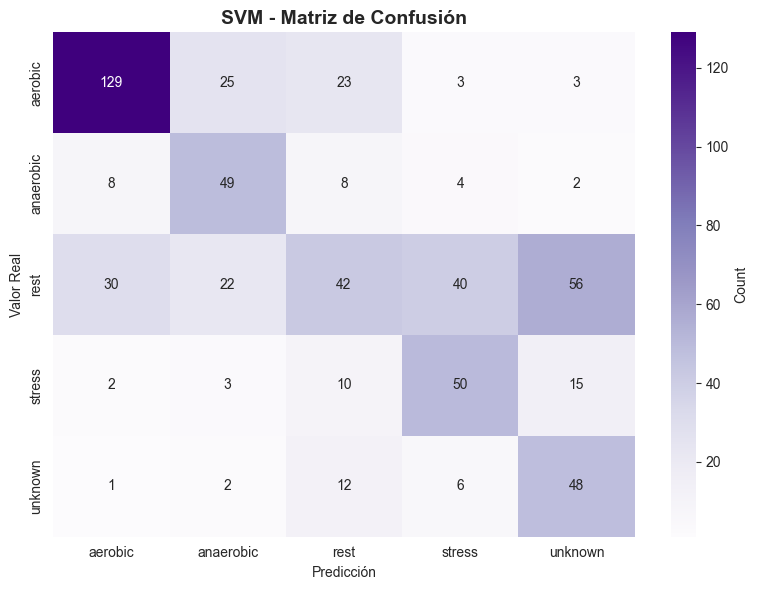

In [36]:
cm_svm = confusion_matrix(y_test, pred_svm, labels=le.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Count'})
plt.title('SVM - Matriz de Confusión', fontsize=14, fontweight='bold')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

### 4.3 Gradient Boosting

In [37]:
gb_clf = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

gb_clf.fit(X_train_scaled, y_train)
pred_gb = gb_clf.predict(X_test_scaled)

acc_gb = accuracy_score(y_test, pred_gb)
f1_gb = f1_score(y_test, pred_gb, average='macro')
balanced_acc_gb = balanced_accuracy_score(y_test, pred_gb)

print("GRADIENT BOOSTING")
print(f"Accuracy: {acc_gb:.4f}")
print(f"Balanced Accuracy: {balanced_acc_gb:.4f}")
print(f"Macro F1-Score: {f1_gb:.4f}")
print(f"\n{classification_report(y_test, pred_gb)}")

GRADIENT BOOSTING
Accuracy: 0.6914
Balanced Accuracy: 0.6385
Macro F1-Score: 0.6626

              precision    recall  f1-score   support

     aerobic       0.78      0.85      0.81       183
   anaerobic       0.79      0.65      0.71        71
        rest       0.59      0.71      0.64       190
      stress       0.67      0.54      0.60        80
     unknown       0.69      0.45      0.54        69

    accuracy                           0.69       593
   macro avg       0.71      0.64      0.66       593
weighted avg       0.70      0.69      0.69       593



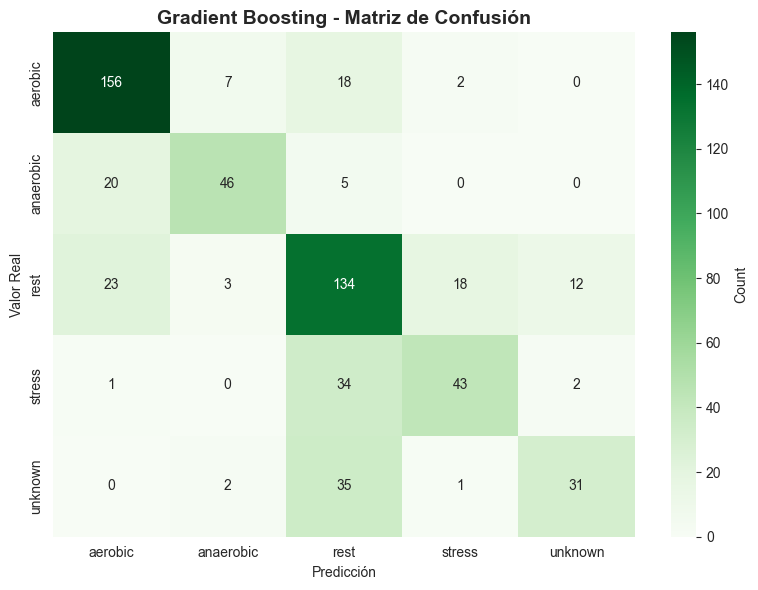

In [38]:
cm_gb = confusion_matrix(y_test, pred_gb, labels=le.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Gradient Boosting - Matriz de Confusión', fontsize=14, fontweight='bold')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

### 4.4 XGBoost

In [45]:
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False
)

xgb_clf.fit(X_train_scaled, y_train_enc)
pred_xgb_enc = xgb_clf.predict(X_test_scaled)
pred_xgb = le.inverse_transform(pred_xgb_enc)

acc_xgb = accuracy_score(y_test, pred_xgb)
f1_xgb = f1_score(y_test, pred_xgb, average='macro')
balanced_acc_xgb = balanced_accuracy_score(y_test, pred_xgb)

print("XGBOOST")
print(f"Accuracy: {acc_xgb:.4f}")
print(f"Balanced Accuracy: {balanced_acc_xgb:.4f}")
print(f"Macro F1-Score: {f1_xgb:.4f}")
print(f"\n{classification_report(y_test, pred_xgb)}")

XGBOOST
Accuracy: 0.7133
Balanced Accuracy: 0.6677
Macro F1-Score: 0.6927

              precision    recall  f1-score   support

     aerobic       0.78      0.87      0.82       183
   anaerobic       0.84      0.65      0.73        71
        rest       0.62      0.71      0.66       190
      stress       0.68      0.57      0.62        80
     unknown       0.76      0.54      0.63        69

    accuracy                           0.71       593
   macro avg       0.73      0.67      0.69       593
weighted avg       0.72      0.71      0.71       593



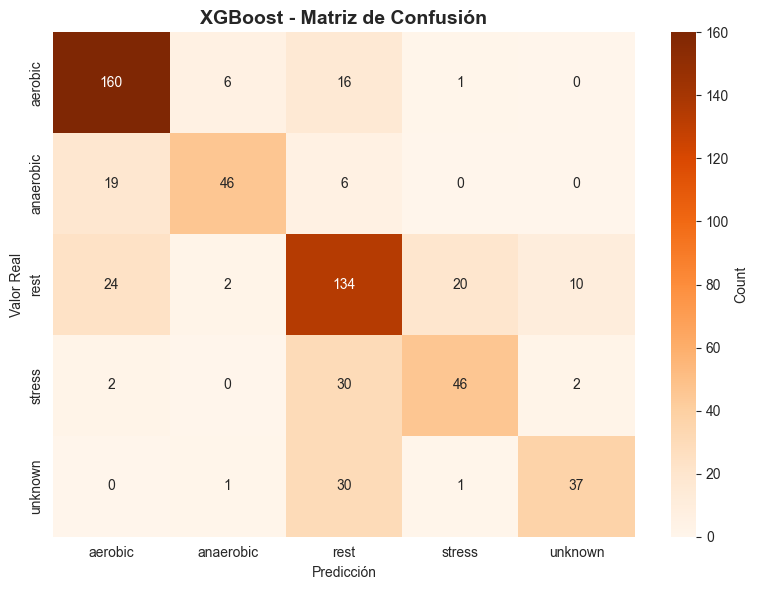

In [46]:
cm_xgb = confusion_matrix(y_test, pred_xgb, labels=le.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Count'})
plt.title('XGBoost - Matriz de Confusión', fontsize=14, fontweight='bold')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

### 4.5 Comparación de Modelos Baseline (70/30)

In [ ]:
results_baseline = pd.DataFrame({
    'Modelo': ['Random Forest', 'SVM', 'Gradient Boosting', 'XGBoost'],
    'Accuracy': [acc_rf, acc_svm, acc_gb, acc_xgb],
    'Balanced Accuracy': [balanced_acc_rf, balanced_acc_svm, balanced_acc_gb, balanced_acc_xgb],
    'Macro F1': [f1_rf, f1_svm, f1_gb, f1_xgb]
})

print("COMPARACIÓN BASELINE")
print(results_baseline.to_string(index=False))
print("\nMejor modelo:", results_baseline.loc[results_baseline['Accuracy'].idxmax(), 'Modelo'])


COMPARACIÓN BASELINE (70/30 Split)
           Modelo  Accuracy  Balanced Accuracy  Macro F1
    Random Forest  0.679595           0.644604  0.659570
              SVM  0.536256           0.587353  0.527848
Gradient Boosting  0.691400           0.638477  0.662622
          XGBoost  0.713322           0.667740  0.692748

Mejor modelo: XGBoost


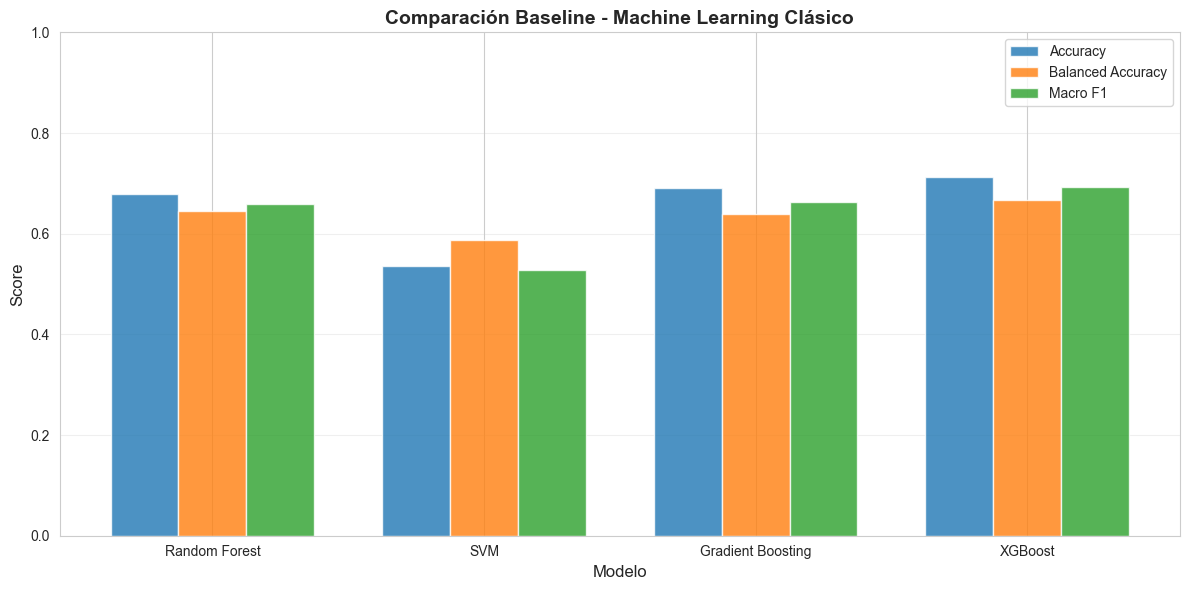

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(results_baseline))
width = 0.25

ax.bar(x - width, results_baseline['Accuracy'], width, label='Accuracy', alpha=0.8)
ax.bar(x, results_baseline['Balanced Accuracy'], width, label='Balanced Accuracy', alpha=0.8)
ax.bar(x + width, results_baseline['Macro F1'], width, label='Macro F1', alpha=0.8)

ax.set_xlabel('Modelo', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comparación Baseline - Machine Learning Clásico', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_baseline['Modelo'])
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

## 5. Validación Leave-One-Subject-Out (LOSO)

Evaluación **realista** de generalización inter-sujeto. Esta métrica es más relevante para aplicaciones reales donde el modelo debe funcionar con nuevos usuarios.

**Importante**: Los resultados LOSO son típicamente mucho más bajos que el baseline 70/30 debido a la alta variabilidad fisiológica inter-individual. Este será el benchmark principal para comparar con Deep Learning.

In [ ]:
unique_subjects = df['subject_id'].unique()
n_subjects = len(unique_subjects)

acc_rf_loso = []
f1_rf_loso = []
acc_xgb_loso = []
f1_xgb_loso = []

Ejecutando LOSO con 39 sujetos...
Esto puede tomar varios minutos.



In [48]:
for i, test_subject in enumerate(unique_subjects, 1):
    mask_test = (subjects == test_subject)
    mask_train = ~mask_test
    
    X_train_loso = X[mask_train]
    y_train_loso = y[mask_train]
    X_test_loso = X[mask_test]
    y_test_loso = y[mask_test]
    
    if len(X_test_loso) == 0 or len(np.unique(y_train_loso)) < len(le.classes_):
        continue
    
    scaler_loso = StandardScaler()
    X_train_loso_scaled = scaler_loso.fit_transform(X_train_loso)
    X_test_loso_scaled = scaler_loso.transform(X_test_loso)
    
    rf_loso = RandomForestClassifier(
        n_estimators=200, max_depth=15, min_samples_split=5,
        min_samples_leaf=2, random_state=42, n_jobs=-1, class_weight='balanced'
    )
    rf_loso.fit(X_train_loso_scaled, y_train_loso)
    pred_rf_loso = rf_loso.predict(X_test_loso_scaled)
    
    acc_rf_loso.append(accuracy_score(y_test_loso, pred_rf_loso))
    f1_rf_loso.append(f1_score(y_test_loso, pred_rf_loso, average='macro', zero_division=0))
    
    y_train_loso_enc = le.transform(y_train_loso)
    y_test_loso_enc = le.transform(y_test_loso)
    
    xgb_loso = XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        eval_metric='mlogloss', use_label_encoder=False
    )
    xgb_loso.fit(X_train_loso_scaled, y_train_loso_enc, verbose=False)
    pred_xgb_loso_enc = xgb_loso.predict(X_test_loso_scaled)
    
    acc_xgb_loso.append(accuracy_score(y_test_loso_enc, pred_xgb_loso_enc))
    f1_xgb_loso.append(f1_score(y_test_loso_enc, pred_xgb_loso_enc, average='macro', zero_division=0))
    
    if i % 5 == 0 or i == n_subjects:
        print(f"Progreso: {i}/{n_subjects} sujetos")

Progreso: 5/39 sujetos
Progreso: 10/39 sujetos
Progreso: 10/39 sujetos
Progreso: 15/39 sujetos
Progreso: 15/39 sujetos
Progreso: 20/39 sujetos
Progreso: 20/39 sujetos
Progreso: 25/39 sujetos
Progreso: 25/39 sujetos
Progreso: 30/39 sujetos
Progreso: 30/39 sujetos
Progreso: 35/39 sujetos
Progreso: 35/39 sujetos
Progreso: 39/39 sujetos
Progreso: 39/39 sujetos


In [49]:
print("RESULTADOS LOSO - GENERALIZACIÓN INTER-SUJETO")

print("\nRANDOM FOREST")
print(f"Accuracy: {np.mean(acc_rf_loso):.4f} ± {np.std(acc_rf_loso):.4f}")
print(f"Macro F1: {np.mean(f1_rf_loso):.4f} ± {np.std(f1_rf_loso):.4f}")
print(f"Mediana: {np.median(acc_rf_loso):.4f}")
print(f"Rango: {np.min(acc_rf_loso):.4f} - {np.max(acc_rf_loso):.4f}")

print("\nXGBOOST")
print(f"Accuracy: {np.mean(acc_xgb_loso):.4f} ± {np.std(acc_xgb_loso):.4f}")
print(f"Macro F1: {np.mean(f1_xgb_loso):.4f} ± {np.std(f1_xgb_loso):.4f}")
print(f"Mediana: {np.median(acc_xgb_loso):.4f}")
print(f"Rango: {np.min(acc_xgb_loso):.4f} - {np.max(acc_xgb_loso):.4f}")

RESULTADOS LOSO - GENERALIZACIÓN INTER-SUJETO

RANDOM FOREST
Accuracy: 0.4687 ± 0.1703
Macro F1: 0.3194 ± 0.1415
Mediana: 0.4512
Rango: 0.0000 - 0.8571

XGBOOST
Accuracy: 0.4621 ± 0.1735
Macro F1: 0.3286 ± 0.1584
Mediana: 0.4508
Rango: 0.0000 - 0.8393


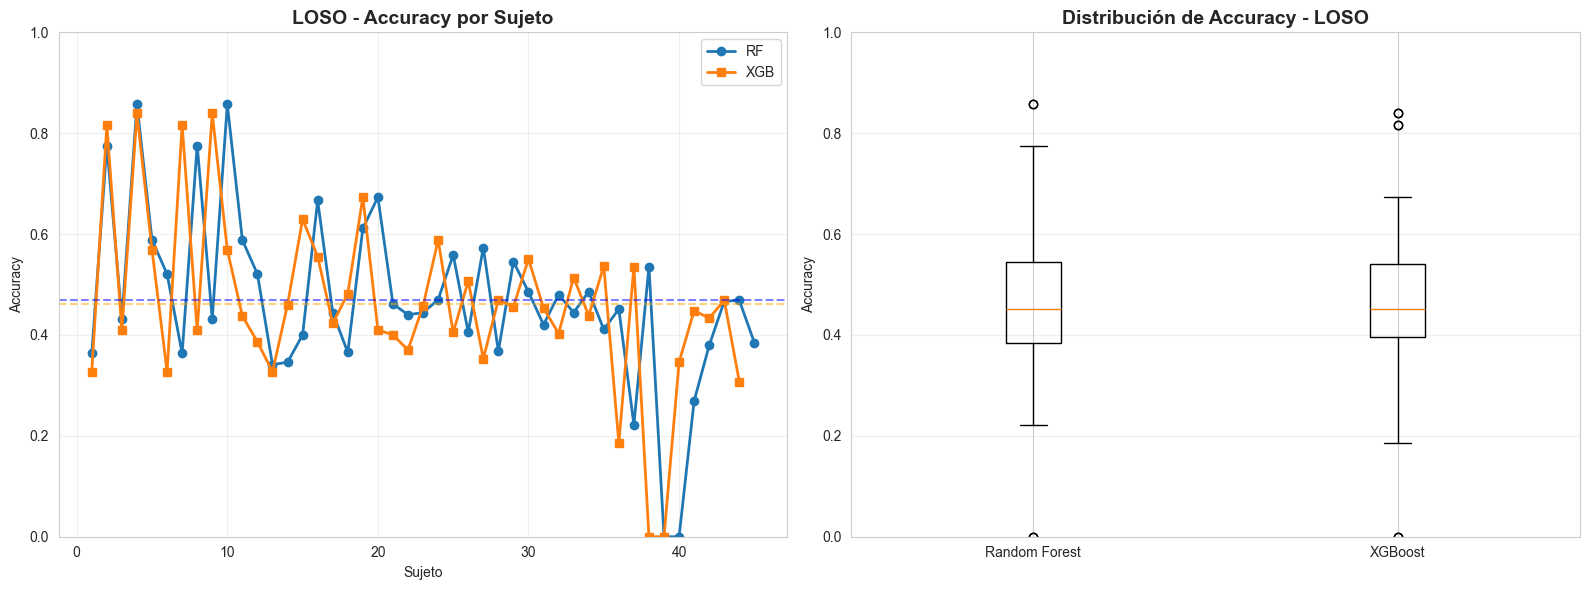

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(range(1, len(acc_rf_loso) + 1), acc_rf_loso, 
             label="RF", marker="o", linewidth=2)
axes[0].plot(range(1, len(acc_xgb_loso) + 1), acc_xgb_loso, 
             label="XGB", marker="s", linewidth=2)
axes[0].axhline(np.mean(acc_rf_loso), color='blue', linestyle='--', alpha=0.5)
axes[0].axhline(np.mean(acc_xgb_loso), color='orange', linestyle='--', alpha=0.5)
axes[0].set_title("LOSO - Accuracy por Sujeto", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Sujeto")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

axes[1].boxplot([acc_rf_loso, acc_xgb_loso], labels=['Random Forest', 'XGBoost'])
axes[1].set_title('Distribución de Accuracy - LOSO', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Accuracy')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

## 6. Conclusiones

### Resultados Baseline Obtenidos

Este notebook estableció las métricas baseline con Machine Learning que servirán como referencia para evaluar los modelos de Deep Learning.

#### Observaciones Clave:

1. **Baseline**:
   - Representa el límite superior con features handcrafted
   - No realista para aplicaciones con nuevos usuarios

2. **LOSO**:
   - Refleja la dificultad real de generalización inter-sujeto
   - Alta variabilidad fisiológica entre individuos

3. **Limitaciones de ML Clásico con Features Handcrafted**:
   - Puede perder información temporal importante
   - No captura automáticamente patrones complejos en las señales

In [51]:
print("RESUMEN")

print("\nBASELINE:")
print(f"   Mejor modelo: {results_baseline.loc[results_baseline['Accuracy'].idxmax(), 'Modelo']}")
print(f"   Accuracy: {results_baseline['Accuracy'].max():.4f}")

print("\nLOSO (Benchmark para DL):")
print(f"   Random Forest - Accuracy: {np.mean(acc_rf_loso):.4f} ± {np.std(acc_rf_loso):.4f}")
print(f"   XGBoost - Accuracy: {np.mean(acc_xgb_loso):.4f} ± {np.std(acc_xgb_loso):.4f}")

RESUMEN

BASELINE:
   Mejor modelo: XGBoost
   Accuracy: 0.7133

LOSO (Benchmark para DL):
   Random Forest - Accuracy: 0.4687 ± 0.1703
   XGBoost - Accuracy: 0.4621 ± 0.1735
